Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports

In [1]:
from collections import namedtuple
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

import sklearn.neighbors as neighbors
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# %matplotlib inline

# Python and library versions

In [2]:
packages = [matplotlib, np, pd]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

library .      version
-------        -------
matplotlib       3.1.0
numpy           1.16.4
pandas          0.24.2


# Importing data

We are going to look at sensor logs from the shuttle from the [UCI learning repository](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29). The last column is the (manual) classification of the operational mode of the shuttle.

There are no labels for the sensors, or a header row in the data, so we will manually construct the heading names `attr_0` through `attr_8` for the sensor data, and `class` for the operational mode's code.

In [3]:
col_names = [f'attr_{n}' for n in range(9)] + ['class']
df = pd.read_csv('shuttle.tst', delim_whitespace=True, names=col_names)

We are going to simulate outlier detection by 
- making class 1 (~80%) the inliners
- dropping the next largest class (class 4)
- combining all other classes as outliers

Before dropping the class column, let's look at the frequency of each class:

In [4]:
df['class'].value_counts()

1    11478
4     2155
5      809
3       39
2       13
6        4
7        2
Name: class, dtype: int64

Now to exchange the "class" attribute for the "anomaly" attribute

In [5]:
df = df[ df['class']!=4 ]
df['anomaly'] = (df['class'] != 1).astype(bool)
df.drop('class', axis=1, inplace=True)
df.head()

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,anomaly
2,50,-1,89,-7,50,0,39,40,2,False
4,55,2,82,0,54,-6,26,28,2,False
5,41,0,84,3,38,-4,43,45,2,False
6,37,0,100,0,36,-8,63,64,2,False
7,46,0,83,0,46,0,37,36,0,False


In [6]:
df.anomaly.value_counts(normalize=True)

False    0.929769
True     0.070231
Name: anomaly, dtype: float64

We have approximately 7% of the data as anomalous.

Let's evaluate the performance of the IsolationForest on this dataset (see lesson 5 for a discussion of IsolationForest). Note there is nothing special about the isolation forest (except we can skip scaling the data) -- we could use any of the anomaly detection classifiers on this same dataset, provided it implements a `decision_function` method.

# Making our anomaly detector

In [7]:
frac_anomalies = df['anomaly'].sum()/df['anomaly'].size

iso_forest = IsolationForest(behaviour='new', contamination=frac_anomalies, random_state=42)
y_predict = iso_forest.fit_predict(df.drop('anomaly', axis=1))

C:\Users\lingcai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Note that the fraction of prediction for anomaly (`-1`) matches the `frac_anomalies` parameter exactly

In [8]:
msg = f"""
Fraction of anomalies predicted:                 {(y_predict == -1).sum() / y_predict.size}
Fraction of anomalies given to isolation forest: {frac_anomalies}
"""
print(msg)


Fraction of anomalies predicted:                 0.07023086269744835
Fraction of anomalies given to isolation forest: 0.07023086269744835



We can access the raw scores from `iso_forest.decision_function`

In [9]:
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

## Metric: Precision@n

Sklearn does not have formula for precision@n built in, so we will have to write our own. We will demonstrate that they duplicate the results we expect on the toy dataset given on slides 5 and 6 of the presentation.

The formula for P@n is
\begin{equation*}
P@n = \frac{\text{# anomalies in first $n$ entries}}{n}
\end{equation*}
Let's write a function for giving us P@n:

In [10]:
def precision_at_n(y_is_anomaly_true, y_scores, n_max = 0):
    """
    y_scores: list of scores (lower means more likely to be an anomaly)
    y_is_anomaly_true: boolean list, y_is_anomaly_true[i] is True 
    iff the ith point is an anomaly
    
    Returns an array of scores for P@n for n in 1, 2, 3, ...., n_max.
    
    If n_max is given as 0, ranks P@n for the entire dataset
    """
    if not n_max:
        n_max = len(y_scores)
    
    is_anomaly_sorted_by_score = [is_anomaly for _, 
                                  is_anomaly in sorted(zip(y_scores, y_is_anomaly_true))]
    return [sum(is_anomaly_sorted_by_score[:n])/n for n in range(1, n_max+1)]

We can check this on the 4 row example we gave in lecture, where rows 1 and 3 were anomalies

In [11]:
y_scores = np.array([-0.03598, -0.033510, -0.005384, 0.000330])
y_true = np.array([1, 0, 1, 0])
# demonstrate it on example given in lecture, where rows 1 and 3 were anomalous
precision_at_n(y_true, y_scores)

[1.0, 0.5, 0.6666666666666666, 0.5]

In [12]:
def custom_average_precision(y_is_anomaly_true, y_scores):
    sorted_scores_and_truth = np.array([(score, is_anomaly) 
                                        for score, is_anomaly in 
                                        sorted(zip(y_scores, y_is_anomaly_true))])
    scores, is_anomaly = sorted_scores_and_truth[:, 0], sorted_scores_and_truth[:, 1]
    p_at_n = np.array(precision_at_n(is_anomaly, y_scores))
    return (is_anomaly * p_at_n).sum() / is_anomaly.sum()

In [13]:
# Apply this to the version given on slides
custom_average_precision(y_true, y_scores)

0.8333333333333333

**Warning:**

Sklearn also provides a very similar looking `average_precision_score` in `sklearn.metrics`. The documentation for the function is provided [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html).

This function is a little odd to use, because it is primarily used for classification problems (where the score is interpreted as a _higher_ score means _more_ likely to be the positive class). Most of our `decision_functions` output have anomalies default to class `-1`, and a _lower_ (i.e. more negative score) means the point is _more_ likely to be an anomaly.

There are two fixes:
* if `y_score` is an `np.array`, we can pass in `-y_score` to put the ordering the way *sklearn* expects it.
* we can set the `pos_label` to 0 (easy to do with a keyword argument, but harder for next reader of our code to understand).

In [14]:

print(f"""
Setting the pos_label to class 0: {average_precision_score(y_true, y_scores, pos_label=0)}
Using the negative score:         {average_precision_score(y_true, -y_scores)}""")


Setting the pos_label to class 0: 0.8333333333333333
Using the negative score:         0.8333333333333333


## Precision@n for the shuttle data set

Let's look at what P@n and Average Precision look like on the shuttle dataset.

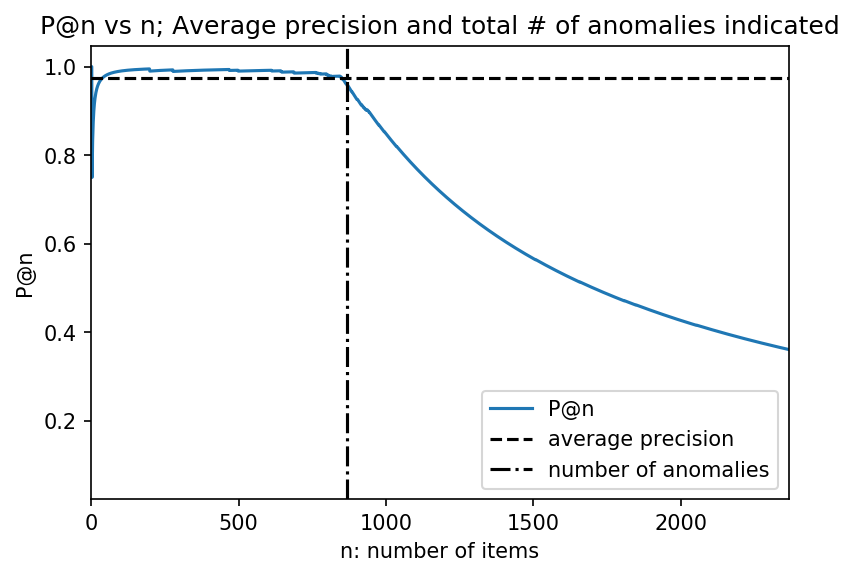

In [15]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = average_precision_score(df['anomaly'], -y_scores)
plt.figure(dpi=150)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n')
plt.axhline(average_precision, linestyle='--', color='k', 
            label='average precision')
plt.axvline(num_anomalies, linestyle='-.', color='k', label='number of anomalies')
plt.xlim(0, num_anomalies + 1500)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Average precision and total # of anomalies indicated');

In [16]:
print(f"The value for average precision is {average_precision:6.4f}")

The value for average precision is 0.9736


We see that P@n depends on the number of items $n$ quite strongly for small n ($n \ll 50$), but then stays relatively constant until $n\sim 869$, the number of anomalies in the data. After that, putting more items from the ranked list just decreases the average precision as the power law $1/n$.

The average precision is only averaged at the location of the anomalies (i.e. early in the dataset), so it is a lot higher than the average of P@n.

What about focusing on that dip at the beginning when $n$ is small?

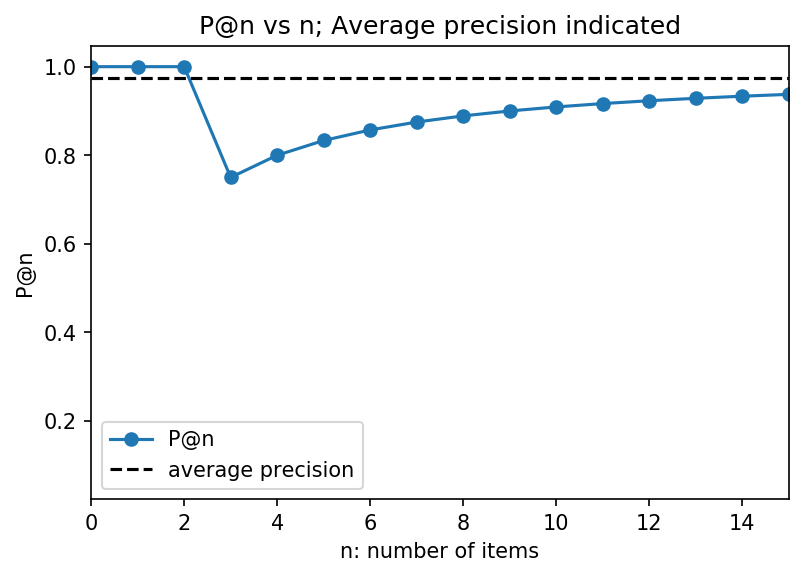

In [17]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = average_precision_score(df['anomaly'], -y_scores)
plt.figure(dpi=150)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n', marker='o')
plt.axhline(average_precision, linestyle='--', color='k', 
            label='average precision')
plt.xlim(0, 15)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Average precision indicated');

At low values of $n$, P@n can be very noisy.

### The adjusted P@n and adjusted average precision

This is not provided by *sklearn* either, but the manipulations to get adjusted P@n from raw P@n are simple:

In [18]:
# reset the scores to those produced by our model
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
num_points = df['anomaly'].size
frac_anomalies = num_anomalies / num_points

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

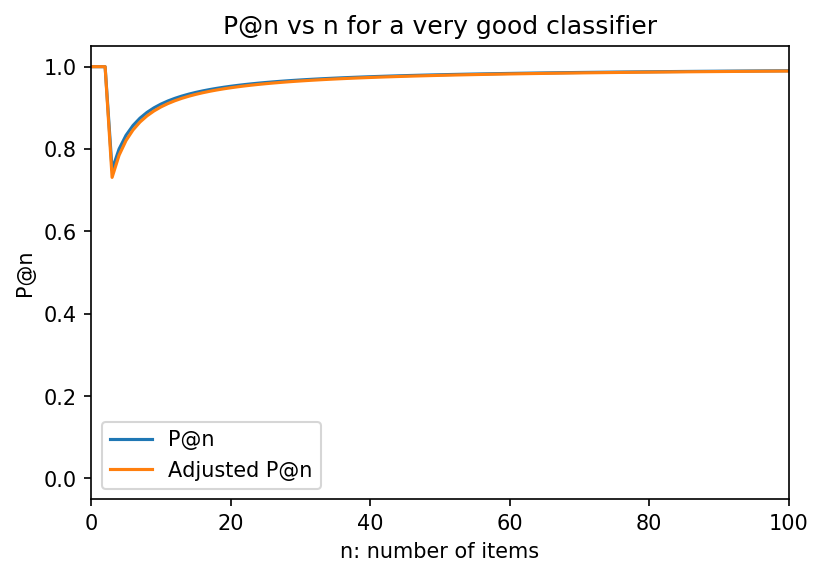

In [19]:
plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 100)
plt.legend()
plt.title('P@n vs n for a very good classifier');

This classifier does such a good job, we are getting close to optimal performance. We can train a worse version of isolation forest for comparison:

In [20]:
bad_iso_forest = IsolationForest(n_estimators = 3, behaviour='new', contamination=frac_anomalies, random_state=42)
bad_iso_forest.fit(df.drop('anomaly', axis=1))
bad_y_scores = bad_iso_forest.decision_function(df.drop('anomaly', axis=1))

p_at_n = np.array(precision_at_n(df['anomaly'], bad_y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -bad_y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

C:\Users\lingcai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


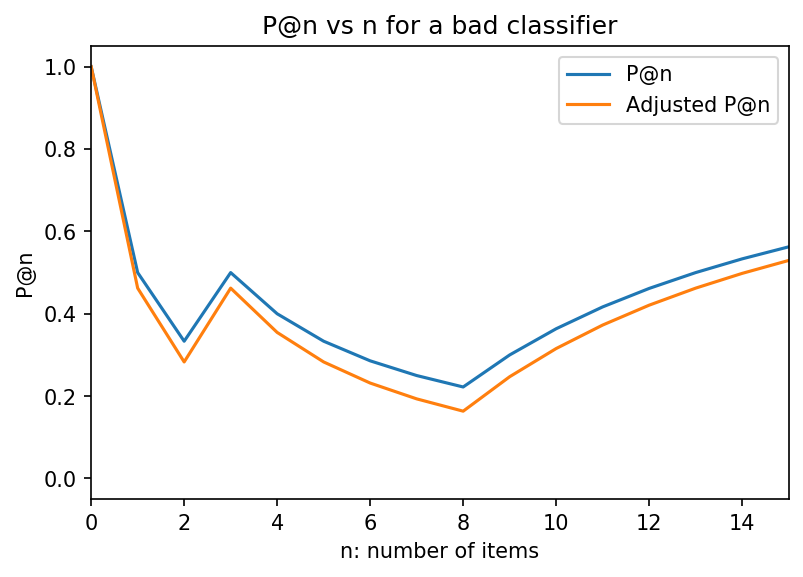

In [21]:
plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 15)
plt.legend()
plt.title('P@n vs n for a bad classifier');

As n is small, we see the effect of applying the “adjustment” (i.e. how well the classifier performs compared to random rankings).


## Same data, different algorithm

Let's use some of the distance based algorithms we have seen earlier (lesson 4). To make _good_ anomaly detection methods, we should apply 
- scaling of features
- maybe apply PCA for dimensional reduction.

We will take a naive approach and score the results using P@n and average precision. Then we will treat the data again with the proper preprocessing steps, and see how the results improve.

In [22]:
# from lecture 4, where we use the average distance of a point to its n_neighbors to score it
def do_nn_avg_outlier_scores(obs, n_neighbors=1):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists.mean(axis=1)
    return scores

In [23]:
features = df.drop('anomaly', axis=1)

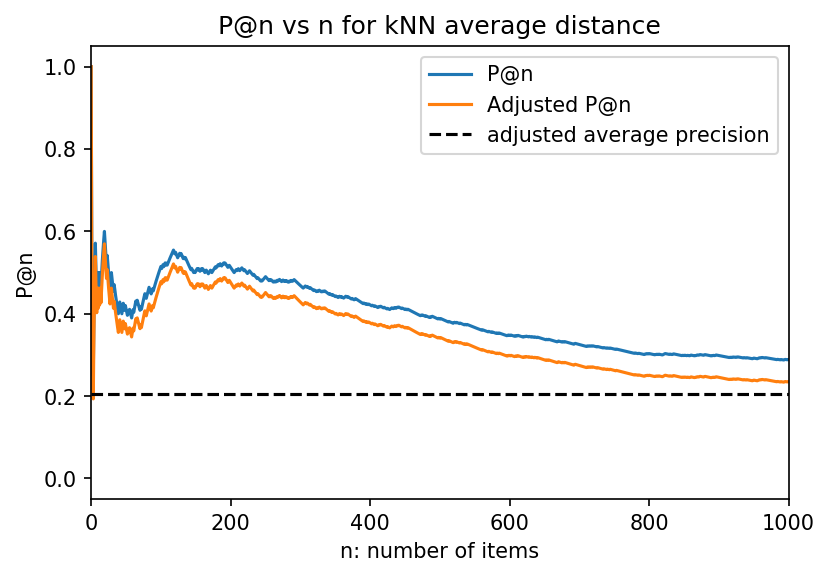

In [24]:
# we want lower numbers (i.e. larger negative distances) to be more likely to be outliers
y_scores = -do_nn_avg_outlier_scores(features, n_neighbors=20)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k', 
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n for kNN average distance');

In [25]:
# scan for the best value of n (may take a while)
ap = [(average_precision_score(df['anomaly'], do_nn_avg_outlier_scores(features, n_neighbors=n)), n)
      for n in range(2, 100)]

In [26]:
sorted(ap, reverse=True)[:5]

[(0.3219912698218204, 99),
 (0.3216555179365431, 98),
 (0.3212325567133122, 97),
 (0.32084458473248517, 96),
 (0.3204533230010461, 95)]

Looks like we get the best results for average precision with 99 neighbors!

## Using kNN again, but with scaling and dimensional reduction

As discussed in Lesson 5, we need to do standard scaling when using distance based methods. The kNN method above demonstrates a _bad_ anomaly detector. We can see how our metrics can measure the difference between kNN done properly (with scaling and dimensional reduction) versus a naive method.

In [27]:
ssX = StandardScaler()
features_scaled = ssX.fit_transform(features.astype(float))

# How many features do we need?
pca = PCA()
pca.fit(features_scaled)
np.cumsum(pca.explained_variance_ratio_)

array([0.32991315, 0.52650241, 0.67768337, 0.81931787, 0.92839029,
       0.99980226, 0.9998828 , 0.99995741, 1.        ])

Looks like 6 components captures 99.9% of the variance, so we will reduce the dimensionality of our data accordingly.

In [28]:
pca = PCA(n_components=6)
pca_features = pca.fit_transform(features_scaled)

Now let us try some different values of $k$ to see how many neighbors we should use. We will keep track of the average precision score, and the value of $k$ that gave us that score:

In [29]:
# Warning: this cell takes about 90 seconds to run!
ap = [(average_precision_score(df['anomaly'], do_nn_avg_outlier_scores(pca_features, n_neighbors=n)), n) 
      for n in range(100, 200)]

In [30]:
# Now look at the average precision score for different numbers of nearest neighbors
sorted(ap, reverse=True)[:5]

[(0.30670148164768646, 199),
 (0.30588834605370524, 198),
 (0.3051231212974257, 197),
 (0.304370363793823, 196),
 (0.3036199874348088, 195)]

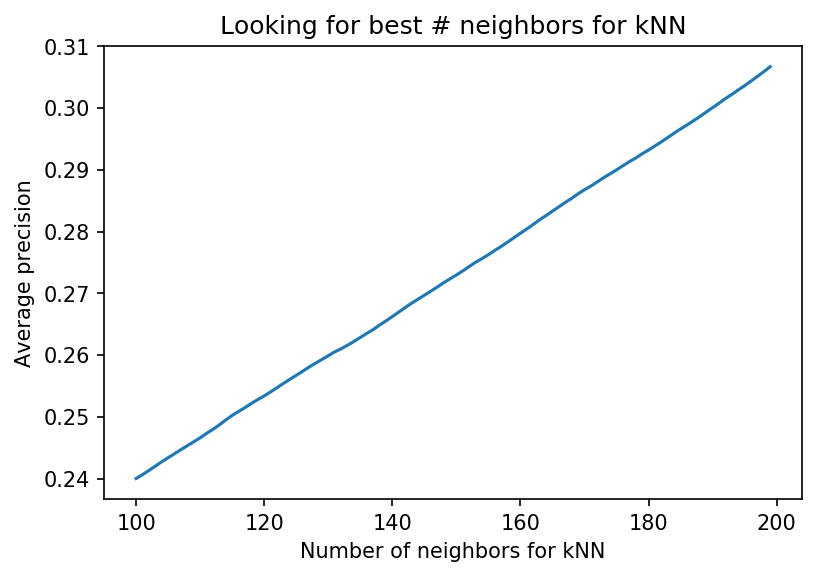

In [31]:
plt.figure(dpi=150)
plt.plot(np.array(ap)[:,1], np.array(ap)[:, 0])
plt.title('Looking for best # neighbors for kNN')
plt.ylabel('Average precision')
plt.xlabel('Number of neighbors for kNN');

The score keeps increasing with the number of neighbors (i.e. we should keep increasing the number of neighbors beyond 200). Some experimentation shows that `n_neighbors` $\approx 600$ maximizes the average precision.

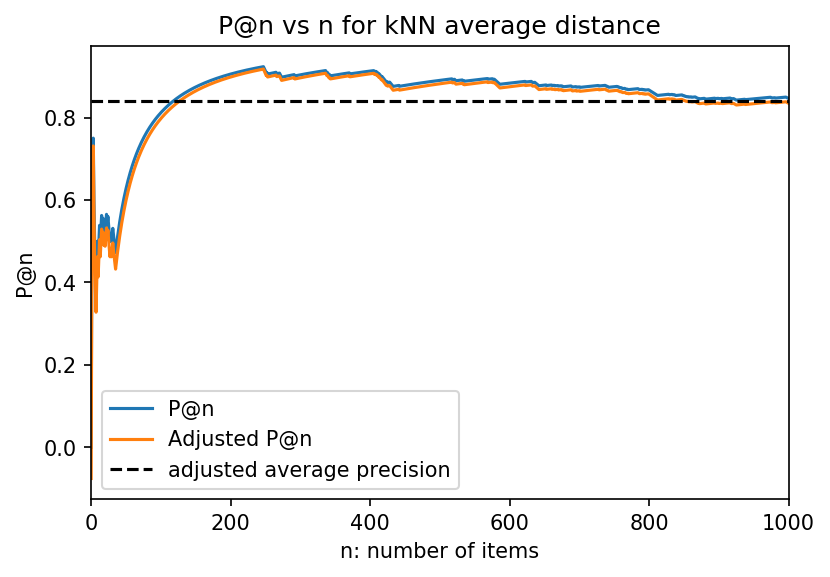

In [32]:
y_scores = -do_nn_avg_outlier_scores(pca_features, n_neighbors=600)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k', 
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n for kNN average distance');

## Using ROC

One of the standard metrics commonly used for both classification and anomaly detection is the Receiver Operator Characteristic Curve (ROC Curve). The curve shows the tradeoff between the false positive and false negative rates as the threshold for the score is varied.

The threshold can either be chosen as a cutoff score (typical for classification) or a cutoff rank (typical for anomaly detection problems).

The _area under the curve_ gives us a single number that tells us how well the classifier does at distinguishing between the two cases. The number can be interpreted as the probability that a randomly chosen anomaly has a higher score than a randomly chosen normal point.

\begin{equation*}
\text{AUC} = P(\text{score of random anomaly} > \text{score of random inlier})
\end{equation*}

In [33]:
roc_model = namedtuple('roc_model', 'name model_scores')

Getting the ROC AUC scores for the different models is straightforward:

In [34]:
roc_models = [
    roc_model('Isolation Forest', -iso_forest.decision_function(features)),
    roc_model('kNN no proprocessing', do_nn_avg_outlier_scores(features, n_neighbors=20)),
    roc_model('kNN processing', do_nn_avg_outlier_scores(pca_features, n_neighbors=600))
]

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    print(label)

Isolation Forest (0.9963)
kNN no proprocessing (0.8002)
kNN processing (0.9918)


We can also make the plot with all three ROC curves on it:

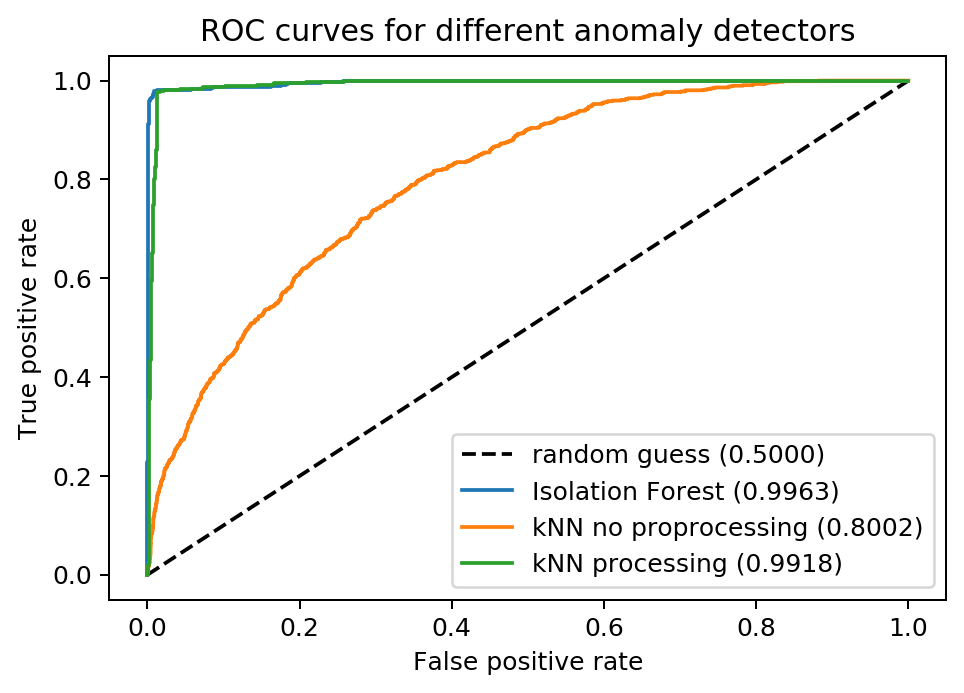

In [35]:
plt.figure(dpi=180)

plt.plot([0,1], [0,1], 'k--', label='random guess (0.5000)')

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    fpr, tpr, _ = roc_curve(df['anomaly'], model.model_scores)
    plt.plot(fpr, tpr, label=label)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves for different anomaly detectors")
plt.legend();

## Final comments 

* Python has a built-in way of generating ROC curves. You will need to write your own functions for precision@n and average precision
* Many datasets that you want to perform anomaly detection on don't have the anomalies labeled. You can process your metrics on classification tasks with similar distributions of data, although you may need to downsample the majority class. 

### Exercise #1

We don't cross-validate the results when fitting hyperparmaters for anomaly detection. Instead, we set a "reasonable range" of hyperparameters (usually determined by experience or a subject matter expert), then look at our metrics as the average over all parameter choice. 

Use $k=500$ to $k=600$ for the processed kNN model.
* What is the mean of the average precision (i.e. take the mean over the 100 models with k ranging from 500 to 600)
* What is the standard error of the average precision (i.e. find the standard error over the same 100 models).

Reminder: standard error is
$$\text{std err} = \frac{\sigma}{\sqrt{N}}$$
where $\sigma$ is the standard deviation and $N$ is the number of models you are averaging over

### Solution #1

In [36]:
# YOUR CODE HERE

### Exercise #2

Make a Local Outlier Factor anomaly detector on the (scaled) shuttle dataset, `pca_features`. What is the area under the ROC curve? Take the number of neighbors to range from 2000 to 3500 in steps of 100, and give the mean and standard error. 

**Resources:** We discussed Local Outlier Factor models in lesson 4, or you can find the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html). 

### Solution #2

In [37]:
# YOUR CODE HERE

### Exercise #3

We have given the interpretation of an ROC score as 
> The probability that a randomly selected "normal" point has a higher score than a randomly selected "anomaly".

Let's check this interpretation. Below is a set of scores for normal points, and a set of scores for anomalies. Calculate the ROC curves using two methods:
1. Using sklearn's `roc_auc_score` method. You will need to join the scores somehow.
2. Randomly drawing a normal point and an anomaly, and comparing the scores. Repeat this 10000 times (with replacement). Give the fraction of times the anomaly had the higher score.

In [38]:
normal_scores = np.random.normal(loc=700, scale=50,size=2000)
anomaly_scores = np.random.normal(loc=800, scale=20,size=80)

### Solution #3

In [39]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. How to apply the metrics Precision@n, average precision, and ROC scores
2. To generate anomaly detection data from classification datasets for baseline evaluation
3. To do parameter scanning without doing cross-validation

Congratulations! This concludes the lesson.

In [40]:
print('end')

end
